## <font color="black" > Dissimilarity-based Sparse Subset Selection </font>

#### Name: Sushilkumar Yadav (21050889)

#### Table of Contents
[Introduction](#0)     
[Problem Statement](#1)                         
[How to find the dissimilarities?](#2)  
[DS3 Algorithm](#3)            
[Dealing with Outliers](#4)     
[Clustering via Representative](#5)       
[DS3 Implementation: Using ADMM Framework](#6)       
[Experiment](#7)       
[Results](#8)       
[Conclusion](#9)       
[Analysis](#10)       
[Drawbacks](#11)                     
[Reference](#12)

<a id="0"></a> 
### Introduction

In [10]:
%%latex
The paper aims to find the data representatives given the pairwise dissimilarities between the source set $\mathbb{X}$ and target set $\mathbb{Y}$ in an unsupervised framework. The paper formulated this as an optimization problem as a row-sparsity regularized trace minimization problem based on simultaneous sparse recovery theory where the  regularization parameter puts a trade-off between the number of representatives and the encoding cost of $\mathbb{Y}$ via representatives.
The proposed algorithm is based on convex programming. While CVX can be used to solve this, but CVX cannot scale well with increase in the problem size. To address this, The authors uses Alternating Direction Methods of Multipliers (ADMM) which has quadratic complexity.  ADMM allows to parallelize the algorithm, hence further reducing the computational time.


<IPython.core.display.Latex object>

<a id="1"></a> 
### Problem Statement

In [11]:
%%latex
Assume the source set is $\mathbb{X}$ and the target set is $\mathbb{Y}$ consisting of $\textbf{M}$ and $\textbf{N}$ elements respectively. The pairwise dissimilarities is given by ${d_{ij}}_{i=0, 1, ...}^{j=0, 1, ...}$ between the elements of $\mathbb{X}$ and $\mathbb{Y}$. Each $d_{ij}$ indicates how well $x_i$ represents target $y_j$. Smaller the value of $d_{ij}$ is, better the $x_i$ represents $y_j$
\begin{equation*}
    \textbf{D} \triangleq 
    \begin{bmatrix}
        d_1^T \\
        .\\
        .\\
        .\\
        d_M^T 
    \end{bmatrix} = \begin{bmatrix}
                        d_{11} & d_{12}&...& d_{1N}\\
                        . & . & \ \ \ \ \ \ \ \ \ \ & .\\
                        . & . & \ \ \ \ \ \ \ \ \ \ & .\\
                        . & . & \ \ \ \ \ \ \ \ \ \ & .\\
                        d_{M1} & d_{M2}&... & d_{MN}
                    \end{bmatrix} \in \mathbb{R}^{M \times N}
\end{equation*}
where $d_i \in \textbf{R}^N$ denotes the $i_{th}$ row of $D$. The goal is to find a small subset of $\mathbb{X}$ that well represents the collection of the elements of $\mathbb{Y}$.

$\mathbb{X}$ and $\mathbb{Y}$ can be of same type of elements/models or of different type of elements/models.

Instead of dissimilarities we can use similarities as well. use relation $d_{ij}$ with $-s_{ij}$, and the algorithm works fine.

<IPython.core.display.Latex object>

<a id="2"></a> 
### How to find the dissimilarities?

In [12]:
%%latex
When appropriate vector-space representations of elements of $\mathbb{X}$ and $\mathbb{Y}$ are given, we can compute dissimilarities using a predefined function, such as the encoding error, e.g., $d_{ij} = \|x_i - Ay_j\|$ for an appropriate $A$, Euclidean distance, $d_{ij} = \|x_i - y_j\|_2$, or truncated quadratic, $d_{ij} = \text{min }{\beta, \|x_i - y_j\|_2^2}$ where $\beta$ is some constant.

<IPython.core.display.Latex object>

<a id="3"></a> 
### DS3 Algorithm

In [13]:
%%latex
let $Z_{ij}$ be the unknown variable associated with dissimilarities $d_{ij}$ to solve the optimization problem. We interpret $z_{ij} \in {0, 1}$ as the indicator of $x_i$ representing $y_j$ , which is one when $x_i$ is the representative of $y_j$ and is zero otherwise. To ensure that each $y_j$ is represented by one representative, we must have $\sum_{i=1}^N z_{ij}=1$.

\begin{equation*}
    \textbf{Z} \triangleq 
    \begin{bmatrix}
        z_1^T \\
        .\\
        .\\
        .\\
        z_M^T 
    \end{bmatrix} = \begin{bmatrix}
                        z_{11} & z_{12}&...& z_{1N}\\
                        . & . & \ \ \ \ \ \ \ \ \ \ & .\\
                        . & . & \ \ \ \ \ \ \ \ \ \ & .\\
                        . & . & \ \ \ \ \ \ \ \ \ \ & .\\
                        z_{M1} & z_{M2}&... & z_{MN}
                    \end{bmatrix} \in \mathbb{R}^{M \times N}
\end{equation*}

We want representatives that can well encode $\mathbb{Y}$. If $x_i$ is chosen to be a representative of $y_j$, the cost of encoding $y_j$ via $x_i$ is $d_{ij} z_{ij} \in \{0, d_{ij}\}$. Hence, the cost of encoding $y_j$ using $\mathbb{X}$ is $\sum_{i=1}^N d_{ij} z_{ij}$ and the cost of encoding $\mathbb{Y}$ via $\mathbb{X}$ is $\sum_{j=1}^N \sum_{i=1}^M d_{ij} z_{ij}$. Also, we want as few representative as possible. 
Therefore the objective function becomes
\begin{equation*}
    \begin{aligned}
        & \operatorname*{min}_{z_{ij}}{\lambda \sum_{i=1}^M \|z\|_p + \sum_{i=1}^M \sum_{j=1}^N d_{ij}z_{ij}}\\
        & \text{s.t. }\sum_{i=1}^M z_{ij} = 1,\ \ \ \forall j; \ \ \ z_{ij} \in \{0, 1\},\ \ \  \forall i, j,
    \end{aligned}
\end{equation*}
The first term in the objective function corresponds to the number of representatives and the second term corresponds to the total cost of encoding $\mathbb{Y}$ via representatives.
Because of binary constraints, the problem becomes NP hard. the optimization problem is relaxed by changing the constraint to $z_{ij} \geq 0$ and removing the indicator function and instead calculating the sum of $\ell p$ - norms of rows of \textbf{Z}. To make the above optimization problem convex, we consider $p \geq 1$. specifically $p \in \{2, \inf\}$ where for $p = 2$, we typically obtain a soft assignment of representatives, i.e., $\{z_{ij}\}$ are in the range [0, 1], while for $p = \infty$, we typically obtain a hard assignment of representatives, i.e., $\{zij\}$ are in \{0, 1\}.
The problem with $p = 1$ is that it promotes only a few points in $\mathbb{Y}$ to be associated with each representative in $\mathbb{X}$

The above optimization problem can be written in the matrix form as 
\begin{equation*}
    \begin{aligned}
        & \operatorname*{min}_{Z} \lambda \|\textbf{Z}\|_{1, p} + tr (\textbf{D}^T, \textbf{Z})\\
        & \text{s.t. } \textbf{1}^T \textbf{Z} = \textbf{1}^T,\ \ \  \textbf{Z} \geq 0
    \end{aligned}
\end{equation*}


<IPython.core.display.Latex object>

<a id="4"></a> 
### Dealing with Outliers

In [14]:
%%latex
The outliers can be detected from source and target sets both. The outlier in the source set corresponds to an element that cannot effectively
represent elements of the target set. This is one of the advantage of finding representatives in this algorithm. The target set, $Y$, may also contain outlier elements, which cannot be encoded efficiently by any element of $X$. Since the optimization program above requires every element
of $\mathbb{Y}$ to be encoded, enforcing outliers to be represented by $\mathbb{X}$ often results in the selection of undesired representatives. In such cases, we would like to detect outliers and allow the optimization
not to encode outliers via representatives.
To solve this, a new variable $e_j \in \{0, 1\}$ is introduced associated with each $y_j$ whose value indicates the probability of $y_j$ being an outlier. 
The Objective function becomes
\begin{equation*}
    \begin{aligned}
        & \operatorname*{min}_{\{z_{ij}\}\{e_{ij}\} }{\lambda \sum_{i=1}^M \|z\|_p + \sum_{i=1}^M \sum_{j=1}^N d_{ij}z_{ij} + \sum_{j=1}^N w_je_j} \\
        & \text{s.t. }\sum_{i=1}^M z_{ij} = 1,\ \ \forall j; \ \ z_{ij} \in \{0, 1\},\ \ \forall i, j,\ \ e_j \geq 0, \forall j
    \end{aligned}
\end{equation*}
When $e_j = 0$, we have $\sum_{i=1}^N z_{ij} = 1$. Hence, $y_j$ is an inlier and must be encoded via $\mathbb{X}$. On the other hand, if $e_j = 1$, we have $\sum_{i=1}^M z_{ij} = 0$. Hence, $y_j$ is an outlier and will not be encoded via $\mathbb{X}$. smaller the value of $w_j$, more likely that $y_j$ be an outlier


<IPython.core.display.Latex object>

<a id="5"></a> 
### Clustering via Representative

In [15]:
%%latex
The optimal solution $Z^*$ not only indicates the elements of $\mathbb{X}$ that are selected as representatives, but also contains information about the membership of elements of $\mathbb{Y}$ to representatives. 
If $\{x_{\ell_1},...., x_{\ell_k} \}$ denotes the set of representatives, then we can assign $y_j$ to the representative $x_{\delta_j}$
according to
\begin{equation*}
    \delta_j = \operatorname*{argmin}_{i \in \{x_{\ell_1},...., x_{\ell_k} \}} d_{ij} 
\end{equation*}
Thus, we can obtain a partitioning of $\mathbb{Y}$ into $\textbf{K}$ groups corresponding to $\textbf{K}$ representatives.


<IPython.core.display.Latex object>

<a id="6"></a> 
### DS3 Implementation: Using ADMM

In [16]:
%%latex
The above optimization can be solved using any integer programming based solver. However, since there are equality constraints, this can be efficiently formulated using Alternating Direction Method of Multipliers (ADMM) framework. Use of ADMM results in computational complexity of $O(MN)$, where $M$ and $N$ are, respectively, the number of rows and columns of the dissimilarity matrix. 
We can perform the below minimization via $M$ independent smaller optimization programs over the $M$ rows of $Z$. Thus having $P$ parallel processing resources, the computational time can be reduced to $O([M/P]N)$.

In case of $p=2$, the solution can be obtained via shrinkage and thresholding operation and in case of $p=\infty$ via projection onto the $\ell_1$ ball. 

To do so, the paper introduced an auxiliary matrix $\textbf{C} \in \mathbb{R}^{M \times N}$, the optimization problem becomes

\begin{equation*}
    \begin{aligned}
        & \operatorname*{min}_{Z, C} \lambda \|\textbf{Z}\|_{1, p} + tr (\textbf{D}^T, \textbf{C}) + \frac{\mu}{2} \|\textbf{Z} - \textbf{C} \|_F^2\\
        & \text{s.t. } \textbf{1}^T \textbf{C} = \textbf{1}^T,\ \ \  \textbf{C} \geq 0,\ \ \ \textbf{Z} = \textbf{C}\\
        & \text{Applying Lagrangian}\\
        & \lambda \|Z\|_{1, p} + tr(D^TC) + \Lambda (Z - C) + \frac{\mu}{2} \|Z - C\|^2_F\\
        & \text{Solving for last 2 term}\\
        & \nu (Z - C) + \frac{\mu}{2} \|Z - C\|^2_F + \frac{1}{2\mu} \|\nu\|^2_2 - \frac{1}{2\mu} \|\nu\|^2_2\\
        & \frac{\mu}{2} \bigg(\|Z - C\|_F^2 + \frac{1}{\mu^{2}} \|\nu\|_2^2 + \frac{2}{\mu} \nu^T (Z - C)\bigg) - \frac{1}{2\mu} \|\nu\|_2^2\\
        & \frac{\mu}{2} \|Z - C + \frac{1}{\mu} \nu \|_2^2 - \frac{1}{2\mu} \|\nu\|_2^2\\
        & \text{Putting this in original lagrangian}\\
        & \mathcal{L}(Z, C, \nu) = \lambda \|Z\|_{1, p} + tr(D^TC) + \frac{\mu}{2} \|Z-C\|_F^2 + \nu (Z - C)\\
        & \mathcal{L}(Z, C, \nu) = \lambda \|Z\|_{1, p} + \frac{\mu}{2} \|Z - C + \frac{1}{\mu} \nu \| - \frac{1}{2\mu} \|\nu\|_F^2 + tr(D^TC)\\
        & \mathcal{L}(Z, C, \nu) = \lambda \|Z\|_{1, p} + \frac{\mu}{2} \|Z - (C - \frac{\nu}{\mu})\|_F^2 + h_1(C, \nu)\\
        & \therefore \mathcal{L} = \sum_{i=1}^M \bigg(\lambda \|Z_{i^*}\|_q + \frac{\mu}{2} \|Z_{i^*} - (C_{i^*} - \frac{\nu_{i^*}}{\mu})\|_2^2\bigg) + h_1(C, \nu)\\
        & \text{Using Alternate Optimization}\\
        & Z^{(k+1)} = \operatorname*{argmin}_{Z} \frac{\lambda}{\mu} \|Z\|_{i, p} + \frac{1}{2} \|Z - (C^{(k)} - \frac{\nu^{(k)}}{\mu})\|_F^2\\
        & C^{(k+1)} = \operatorname*{argmin}_{C} \|C - (Z^{(k+1)} + \frac{\nu^{(k)} + D}{\mu})\|_F^2\\
        & ~~~~~~~~~~~~~ \text{s.t. } 1^TC = 1^T, C \geq 0\\
        & \nu^{(k+1)} = \nu_{(k)} + \mu (Z_{(k+1)} - C^{(k+1)})\\
        & \text{error}_1 = \| Z^{(k+1)} - C^{(k+1)} \|_{\infty}\\
        & \text{error}_2 = \| Z^{(k+1)} - Z^{(k)} \|_{\infty}\\
        & k \leftarrow k + 1\\
        & \text{Optimal Solution: } Z^* = Z^{(k)}
        \cr
    \end{aligned}
\end{equation*}


\begin{equation*}
\\
\\
\overline{
\begin{aligned}\
& \textbf{DS3 Algorithm Pseudocode}\\
& \overline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}\\
& \textbf{Initialization: }  \mathrm{Set\ } \mu=10^{-1}, \epsilon=10^{-7}, \text{maxIter = } 10^5, k=0, Z^{(0)} = C^{(0)} = I, \Lambda^{(0)} = 0  \text{and } \text{error1 } = \text{error2 = }2\epsilon\\
& \textbf{Output: } \text{Optimal Solution: } Z^* = Z^{(k)}\\
& \textbf{while }  {(\text{error1 } > \epsilon\ \text{or } \text{error2 }>\ \epsilon)\ \text{and } (k < \text{ maxIter})} \textbf{ do}\\
    & ~~~~~~~~~~~~\text{Update }Z \text{ and }C\text{ by}\\
    & ~~~~~~~~~~~~Z^{(k+1)} = \operatorname*{argmin}_{Z} \frac{\lambda}{\mu} \|Z\|_{i, p} + \frac{1}{2} \|Z - (C^{(k)} - \frac{\nu^{(k)}}{\mu})\|_F^2\\
    & ~~~~~~~~~~~~C^{(k+1)} = \operatorname*{argmin}_{C} \|C - (Z^{(k+1)} + \frac{\nu^{(k)} + D}{\mu})\|_F^2\\
    & ~~~~~~~~~~~~ ~~~~~~~~~~~~~ \text{s.t. } 1^TC = 1^T, C \geq 0\\
    & ~~~~~~~~~~~~\text{Update the lagrange multiplier matrix by}\\
    & ~~~~~~~~~~~~\nu^{(k+1)} = \nu_{(k)} + \mu (Z_{(k+1)} - C^{(k+1)})\\
    & ~~~~~~~~~~~~\text{Update errors by}\\
    & ~~~~~~~~~~~~\text{error}1 = \| Z^{(k+1)} - C^{(k+1)} \|_{\infty}\\
    & ~~~~~~~~~~~~\text{error}2 = \| C^{(k+1)} - C^{(k)} \|_{\infty}\\
    & ~~~~~~~~~~~~k \leftarrow k + 1\\
    & \textbf{end while}
\end{aligned}
}
\end{equation*}

<IPython.core.display.Latex object>

<a id="7"></a> 
### Experimentation 

In [2]:
%%latex
We performed the experiments using synthetic data points. we computed the dissimilarity matrix using euclidean distances. We first implemented the convex optimization using CVX library (Sedumi Solver), which demonstrates the efficacy of the algorithm. we further experimented using ADMM.  

<IPython.core.display.Latex object>

TypeError: gradient_function() takes 6 positional arguments but 7 were given

C:\Users\96446\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\96446\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\96446\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\96446\AppData\Local\Temp\ipykernel_29432\1429956195.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  x[o[:cut_index]] = np.sign(z[:cut_index]) * np.maximum(zbar - t / cut_index, np.abs(z[cut_index]))


||Z - C||₂ = 5.26e+00, ||C1 - C2||₂ = 1.01e+00,  iteration = 0
||Z - C||₂ = 3.78e-05, ||C1 - C2||₂ = 7.28e-01,  iteration = 100
||Z - C||₂ = 5.93e-05, ||C1 - C2||₂ = 7.31e-01,  iteration = 200
||Z - C||₂ = 1.29e-05, ||C1 - C2||₂ = 7.29e-01,  iteration = 300
||Z - C||₂ = 1.44e-05, ||C1 - C2||₂ = 7.29e-01,  iteration = 400
||Z - C||₂ = 1.67e-05, ||C1 - C2||₂ = 7.29e-01,  iteration = 500
||Z - C||₂ = 8.35e-06, ||C1 - C2||₂ = 7.28e-01,  iteration = 600
||Z - C||₂ = 5.29e-06, ||C1 - C2||₂ = 7.28e-01,  iteration = 700
||Z - C||₂ = 1.81e-06, ||C1 - C2||₂ = 7.27e-01,  iteration = 800
||Z - C||₂ = 1.53e-06, ||C1 - C2||₂ = 7.27e-01,  iteration = 900
||Z - C||₂ = 5.34e-06, ||C1 - C2||₂ = 7.27e-01,  iteration = 1000
||Z - C||₂ = 1.16e-05, ||C1 - C2||₂ = 7.27e-01,  iteration = 1100
||Z - C||₂ = 2.09e-07, ||C1 - C2||₂ = 7.26e-01,  iteration = 1200
||Z - C||₂ = 2.09e-07, ||C1 - C2||₂ = 7.26e-01,  iteration = 1300
||Z - C||₂ = 2.09e-07, ||C1 - C2||₂ = 7.26e-01,  iteration = 1400
||Z - C||₂ = 2.09e-07,

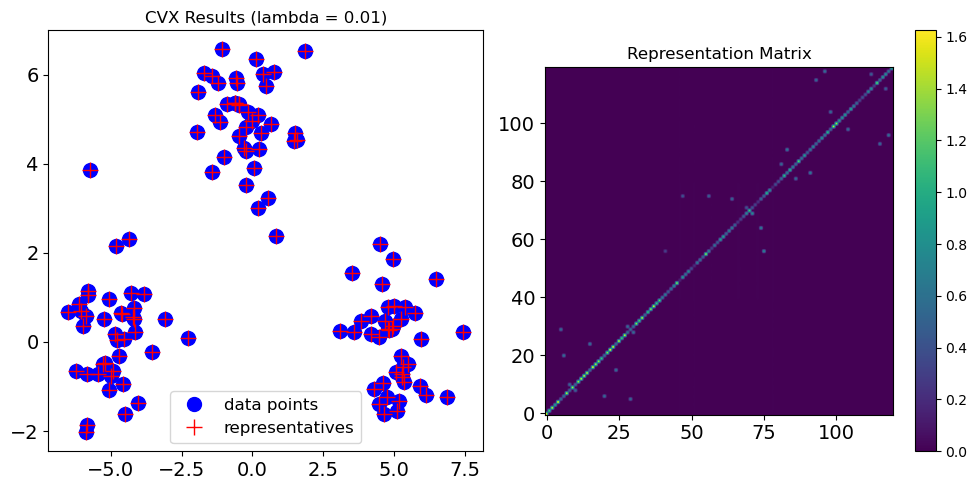

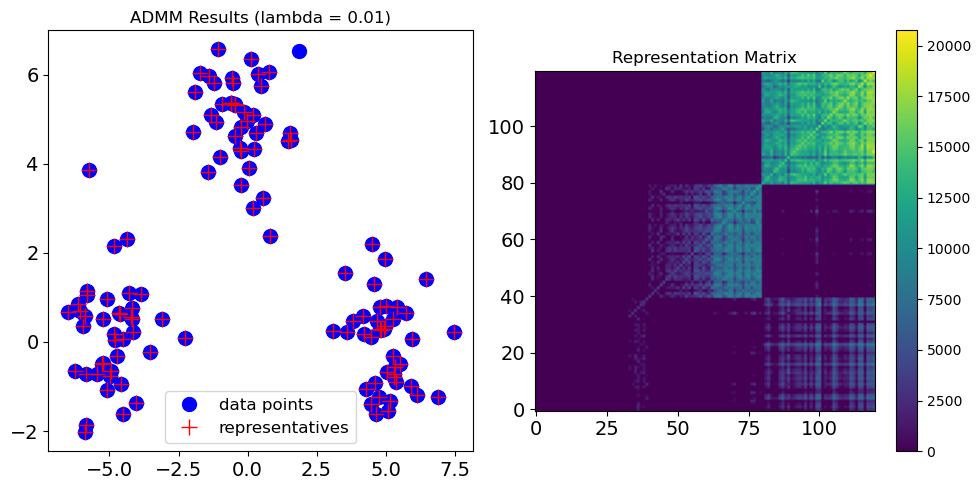

||Z - C||₂ = 3.41e+00, ||C1 - C2||₂ = 5.71e-01,  iteration = 0
||Z - C||₂ = 1.02e-03, ||C1 - C2||₂ = 4.22e-03,  iteration = 100
||Z - C||₂ = 2.29e-05, ||C1 - C2||₂ = 1.93e-02,  iteration = 200
||Z - C||₂ = 3.70e-07, ||C1 - C2||₂ = 1.95e-02,  iteration = 300
||Z - C||₂ = 5.38e-09, ||C1 - C2||₂ = 1.95e-02,  iteration = 400
||Z - C||₂ = 7.44e-11, ||C1 - C2||₂ = 1.95e-02,  iteration = 500
||Z - C||₂ = 9.99e-13, ||C1 - C2||₂ = 1.95e-02,  iteration = 600
||Z - C||₂ = 1.32e-14, ||C1 - C2||₂ = 1.95e-02,  iteration = 700
||Z - C||₂ = 2.55e-16, ||C1 - C2||₂ = 1.95e-02,  iteration = 800
||Z - C||₂ = 4.37e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 900
||Z - C||₂ = 4.96e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1000
||Z - C||₂ = 5.55e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1100
||Z - C||₂ = 5.30e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1200
||Z - C||₂ = 4.81e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1300
||Z - C||₂ = 5.21e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1400
||Z - C||₂ = 5.90e-17,

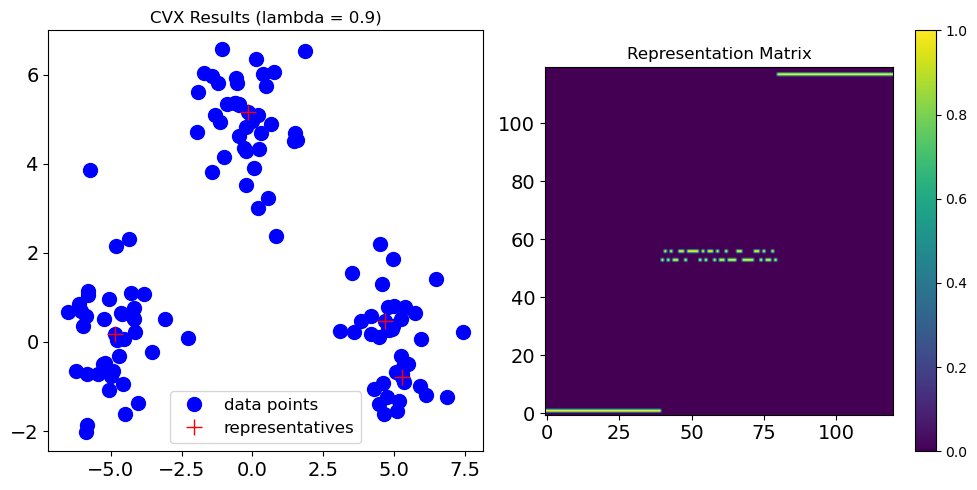

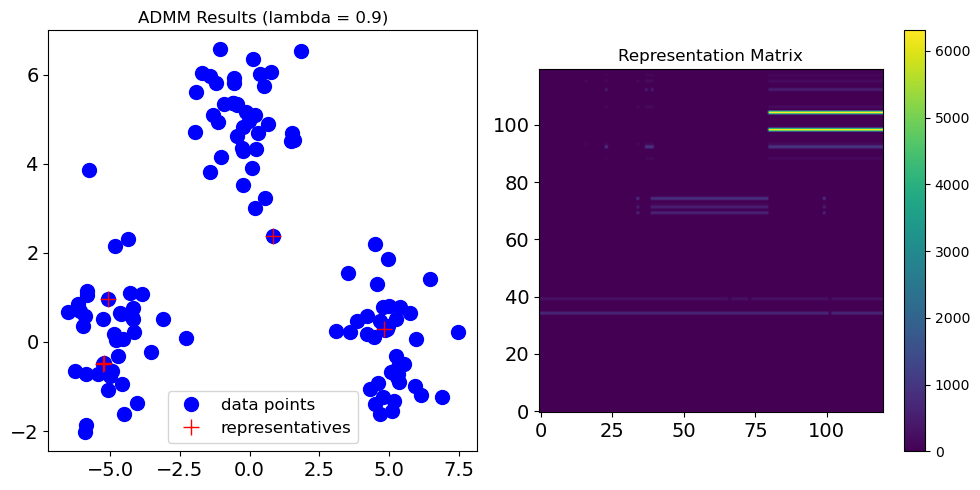

In [226]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

# Computing similarities between source and target
def euclidean_distance(X, Y):
    return np.linalg.norm(X - Y)   

def computeDissimilarity(X, Y=None):
    if Y is None:
        Y = X

    M, N = X.shape[1], Y.shape[1]
    D = np.zeros((M, N))

    for i in range(M):
        for j in range(N):
            D[i, j] = euclidean_distance(X[:, i], Y[:, j])

    return D

def solve_DS3_cvx(D, p, lamda):
    M, N = D.shape

    Z = cp.Variable((M, N), nonneg=True)

    if p == float('inf'):
        objective = cp.Minimize(lamda * cp.sum(cp.max(Z, axis=1)) + cp.trace(D.T @ Z))
    else:
        objective = cp.Minimize(lamda * cp.sum(cp.norm(Z, axis=1)) + cp.trace(D.T @ Z))

    constraints = [cp.sum(Z, axis=0) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, eps=tolerance_factor_cvx, max_iters=maxIter_cvx)

    return Z.value

def plot_results(Y, Z, sInd, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(Y[0, :], Y[1, :], 'o', linewidth=4, color='b', markersize=10, markerfacecolor='b')
    axs[0].plot(Y[0, sInd], Y[1, sInd], '+', linewidth=6, color='r', markersize=12)
    axs[0].legend(['data points', 'representatives'], fontsize=12)
    axs[0].set_title(title)
    axs[0].tick_params(labelsize=14)

    im = axs[1].imshow(Z)
    fig.colorbar(im, ax=axs[1])
    axs[1].set_title("Representation Matrix")
    axs[1].invert_yaxis()
    axs[1].tick_params(labelsize=14)

    plt.tight_layout()
    plt.show()
    
    
'''
Minimizing the Lagrangian function in (12) with respect to Z can be done in O(MN) computational time. 
We can obtain the solution in the case of p=2 via shrinkage and thresholding operation and 
in the case of p=∞ via projection onto the ℓ1 ball
'''
def z_solver(Z_old, lambda_val, p):
    Z_new = np.zeros_like(Z_old)
    if lambda_val.size > 0:
        D, N = Z_old.shape
        if p == 1:
            Z_new = np.maximum(np.abs(Z_old) - np.tile(lambda_val, (N, 1)).T, 0) * np.sign(Z_old)
        elif p == 2:
            r = np.zeros(D)
            for j in range(D):
                r[j] = np.maximum(np.linalg.norm(Z_old[j, :]) - lambda_val[j], 0)
            Z_new = np.tile((r / (r + lambda_val)).reshape(-1, 1), (1, N)) * Z_old
        elif p == np.inf:
            Z_new = np.zeros((D, N))
            for j in range(D):
                y, t = Z_old[j, :],  lambda_val[j]
                x = y.copy()
                o = np.argsort(np.abs(y))[::-1]
                z = y[o]
                cs = np.cumsum(np.abs(z[:-1])) / np.arange(1, len(z))
                cs -= t / np.arange(1, len(z))
                d = cs > np.abs(z[1:])
                cut_index = len(y) if np.sum(d) == 0 else np.min(np.nonzero(d))
                zbar = np.mean(np.abs(z[:cut_index]))
                if cut_index < len(y):
                    x[o[:cut_index]] = np.sign(z[:cut_index]) * np.maximum(zbar - t / cut_index, np.abs(z[cut_index]))
                else:
                    x[o[:cut_index]] = np.sign(z[:cut_index]) * np.maximum(zbar - t / cut_index, 0)
                    
                Z_new[j, :] = x
                
    return Z_new

'''
This part of the code is borrowed from the paper[4] section 3
'''

def solver_simplex(U):
    m, N = U.shape
    V = np.sort(U, axis=1)[:, ::-1] # Sorting the element of vector V
    activeElementSet = np.arange(N)
    theta = np.zeros(N)
    i = 0
    while activeElementSet.size > 0 and i < m:
        idx = (V[i, activeElementSet] - (np.sum(V[0:i+1, activeElementSet], axis=0) - 1) / (i + 1)) <= 0
        # print("idx: ", idx)
        theta[activeElementSet[idx]] = (np.sum(V[0:i, activeElementSet[idx]], axis=0) - 1) / i
        activeElementSet = activeElementSet[~idx]
        i += 1
    # print("theta: ", theta)
    if activeElementSet.size > 0:
        theta[activeElementSet] = (np.sum(V[0:m, activeElementSet], axis=0) - 1) / m
    C = np.maximum(U - np.tile(theta, (m, 1)), 0)
    return C

#Finding the effet of regularizer
def computeLamdaMax(D, q):
    M, N = D.shape
    idx = np.argmin(np.sum(D, axis=1))

    rho_max = -np.inf
    idxC = np.setdiff1d(np.arange(M), idx)
    
    if q == np.inf:
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = np.linalg.norm(v, 1) / 2
            if p > rho_max:
                lamda_max = p
    elif q == 2:
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = np.sqrt(M) * np.linalg.norm(v) ** 2 / (2 * np.sum(v))
            if p > rho_max:
                lamda_max = p

    return lamda_max

def solve_DS3_ADMM(D, p, lamda, maxIter):
    M, N = D.shape

    C1 = np.eye(M, N)
    lamda_var = np.zeros((M, N))
    mu = 1e-1
    epsilon = 1e-7

    error1 = 2 * epsilon
    error2 = 2 * epsilon
    dummy_D = np.ones(D.shape[0])
    lamda_reg = lamda * computeLamdaMax(D, p)
    
    k = 0
    while (error1 > epsilon or error2 > epsilon) and (k < maxIter):

        # Update Z
        # Z = np.linalg.solve((lamda / mu) * np.eye(M) + np.eye(M), (C1 - nu/ mu))
        Z = z_solver(C1 - (lamda_var + D) / mu, lamda_reg / mu * dummy_D, p)
        # Update C
        # C2 = np.minimum(np.maximum(0, Z + (nu + D) / mu), 1)  # Use minimum operation 
        C2 = solver_simplex(Z + lamda_var / mu)
    
        # Update lamda_var
        lamda_var = lamda_var + mu * (Z - C2)

        # Update errors
        error1 = np.sum(np.abs(Z - C2)) / (Z.shape[0] * Z.shape[1])
        error2 = np.sum(np.abs(C1 - C2)) / (Z.shape[0] * Z.shape[1])
        
        if k % 100 == 0:
            print("||Z - C||₂ = {:.2e}, ||C1 - C2||₂ = {:.2e},  iteration = {}\n".format(error1, error2, k))

        # Update iteration counter
        k += 1
        
        C1 = C2

    return Z

def findRepresentatives(matrix, ratio=0.1):
    num_rows = matrix.shape[0]
    row_norms = np.zeros(num_rows)

    for i in range(num_rows):
        row_norms[i] = np.linalg.norm(matrix[i, :], np.inf)

    selected_indices = np.where(row_norms >= ratio * np.linalg.norm(row_norms, np.inf))[0]

    norms_selected = np.zeros(len(selected_indices))
    for i, ind in enumerate(selected_indices):
        norms_selected[i] = np.linalg.norm(matrix[ind, :], ord=2)

    sorted_indices = selected_indices[np.argsort(norms_selected)[::-1]]
    return sorted_indices

beta = 0.5  
tau = 1.0  
p = np.inf
maxIter_cvx = 3000
maxIter = 3000
tolerance_factor_cvx = 0.0

# Generate source and target sets
np.random.seed(42)
# Parameters
num_groups = 3
points_per_group = 40
offsets = np.array([[0, 5], [5, 0], [-5, 0]])   

# Initialize an empty list to store groups of points
X_groups = []

# Generate each group of points with the corresponding offset
for offset in offsets[:num_groups]:
    X_group = np.random.randn(2, points_per_group) + np.expand_dims(offset, axis=1)
    X_groups.append(X_group)

# Concatenate all groups of points along the second axis
X = np.hstack(X_groups)

# Set Y equal to X
Y = X

# Compute dissimilarity matrix
D = computeDissimilarity(X, Y)
D /= np.max(D)

lamda_val = [0.01, 0.9]

for lamda in lamda_val:
    # w = compute_w(D, beta, tau)
    start_time_cvx = time.time()
    Z_cvx = solve_DS3_cvx(D, p, lamda)
    end_time_cvx = time.time()
    cvx_time = end_time_cvx - start_time_cvx

    start_time_ADMM = time.time()
    Z_ADMM = solve_DS3_ADMM(D, p, lamda, maxIter)
    end_time_ADMM = time.time()
    ADMM_time = end_time_ADMM - start_time_ADMM

    print("CVX implementation time:", cvx_time)
    print("ADMM Parallel computation time (Best Case): ", ADMM_time / (num_groups * points_per_group)  )

    sInd_cvx = findRepresentatives(Z_cvx)
    sInd_numpy = findRepresentatives(Z_ADMM)

    plot_results(Y, Z_cvx, sInd_cvx, "CVX Results (lambda = {})".format(lamda))
    plot_results(Y, Z_ADMM, sInd_numpy, "ADMM Results (lambda = {})".format(lamda))

||Z - C||₂ = 3.41e+00, ||C1 - C2||₂ = 5.71e-01,  iteration = 0
||Z - C||₂ = 1.02e-03, ||C1 - C2||₂ = 4.22e-03,  iteration = 100
||Z - C||₂ = 2.29e-05, ||C1 - C2||₂ = 1.93e-02,  iteration = 200
||Z - C||₂ = 3.70e-07, ||C1 - C2||₂ = 1.95e-02,  iteration = 300
||Z - C||₂ = 5.38e-09, ||C1 - C2||₂ = 1.95e-02,  iteration = 400
||Z - C||₂ = 7.44e-11, ||C1 - C2||₂ = 1.95e-02,  iteration = 500
||Z - C||₂ = 9.99e-13, ||C1 - C2||₂ = 1.95e-02,  iteration = 600
||Z - C||₂ = 1.32e-14, ||C1 - C2||₂ = 1.95e-02,  iteration = 700
||Z - C||₂ = 2.55e-16, ||C1 - C2||₂ = 1.95e-02,  iteration = 800
||Z - C||₂ = 4.37e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 900
||Z - C||₂ = 4.96e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1000
||Z - C||₂ = 5.55e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1100
||Z - C||₂ = 5.30e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1200
||Z - C||₂ = 4.81e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1300
||Z - C||₂ = 5.21e-17, ||C1 - C2||₂ = 1.95e-02,  iteration = 1400
||Z - C||₂ = 5.90e-17,

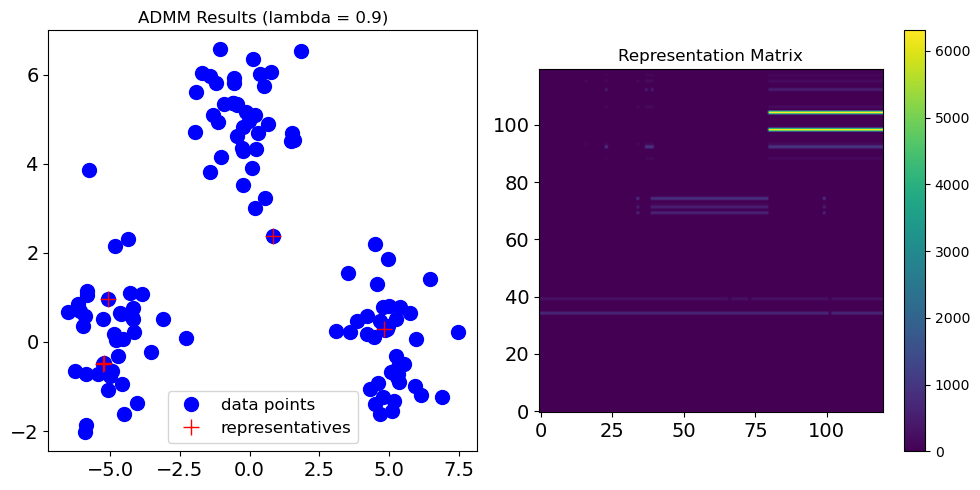

In [233]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
# Computing similarities between source and target
def euclidean_distance(X, Y):
    return np.linalg.norm(X - Y)   

def computeDissimilarity(X, Y=None):
    if Y is None:
        Y = X

    M, N = X.shape[1], Y.shape[1]
    D = np.zeros((M, N))

    for i in range(M):
        for j in range(N):
            D[i, j] = euclidean_distance(X[:, i], Y[:, j])

    return D

def plot_results(Y, Z, sInd, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(Y[0, :], Y[1, :], 'o', linewidth=4, color='b', markersize=10, markerfacecolor='b')
    axs[0].plot(Y[0, sInd], Y[1, sInd], '+', linewidth=6, color='r', markersize=12)
    axs[0].legend(['data points', 'representatives'], fontsize=12)
    axs[0].set_title(title)
    axs[0].tick_params(labelsize=14)

    im = axs[1].imshow(Z)
    fig.colorbar(im, ax=axs[1])
    axs[1].set_title("Representation Matrix")
    axs[1].invert_yaxis()
    axs[1].tick_params(labelsize=14)

    plt.tight_layout()
    plt.show()
    
    
'''
Minimizing the Lagrangian function in (12) with respect to Z can be done in O(MN) computational time. 
We can obtain the solution in the case of p=2 via shrinkage and thresholding operation and 
in the case of p=∞ via projection onto the ℓ1 ball
'''
# z_solver(C1 - (lamda_var + D) / mu, lamda_reg / mu * dummy_D, p)
def z_solver(Z_old, lambda_val, p):
    Z_new = np.zeros_like(Z_old)
    if lambda_val.size > 0:
        D, N = Z_old.shape
        if p == 1:
            Z_new = np.maximum(np.abs(Z_old) - np.tile(lambda_val, (N, 1)).T, 0) * np.sign(Z_old)
        if p == 2:
            r = np.zeros(D)
            for j in range(D):
                r[j] = np.maximum(np.linalg.norm(Z_old[j, :]) - lambda_val[j], 0)
            Z_new = np.tile((r / (r + lambda_val)).reshape(-1, 1), (1, N)) * Z_old
        elif p == np.inf:
            Z_new = np.zeros((D, N))
            for j in range(D):
                y, t = Z_old[j, :],  lambda_val[j]
                x = y.copy()
                o = np.argsort(np.abs(y))[::-1]
                z = y[o]
                cs = np.cumsum(np.abs(z[:-1])) / np.arange(1, len(z))
                cs -= t / np.arange(1, len(z))
                d = cs > np.abs(z[1:])
                cut_index = len(y) if np.sum(d) == 0 else np.min(np.nonzero(d))
                zbar = np.mean(np.abs(z[:cut_index]))
                if cut_index < len(y):
                    x[o[:cut_index]] = np.sign(z[:cut_index]) * np.maximum(zbar - t / cut_index, np.abs(z[cut_index]))
                else:
                    x[o[:cut_index]] = np.sign(z[:cut_index]) * np.maximum(zbar - t / cut_index, 0)

                Z_new[j, :] = x
                
    return Z_new

'''
This part of the code is borrowed from the paper[4] section 3
'''

def solver_simplex(U):
    m, N = U.shape
    V = np.sort(U, axis=1)[:, ::-1] # Sorting the element of vector V
    activeElementSet = np.arange(N)
    theta = np.zeros(N)
    i = 0
    while activeElementSet.size > 0 and i < m:
        idx = (V[i, activeElementSet] - (np.sum(V[0:i+1, activeElementSet], axis=0) - 1) / (i + 1)) <= 0
        # print("idx: ", idx)
        theta[activeElementSet[idx]] = (np.sum(V[0:i, activeElementSet[idx]], axis=0) - 1) / i
        activeElementSet = activeElementSet[~idx]
        i += 1
    # print("theta: ", theta)
    if activeElementSet.size > 0:
        theta[activeElementSet] = (np.sum(V[0:m, activeElementSet], axis=0) - 1) / m
    C = np.maximum(U - np.tile(theta, (m, 1)), 0)
    return C

#Finding the effet of regularizer
def computeLamdaMax(D, q):
    M, N = D.shape
    idx = np.argmin(np.sum(D, axis=1))

    rho_max = -np.inf
    idxC = np.setdiff1d(np.arange(M), idx)
    
    if q == np.inf:
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = np.linalg.norm(v, 1) / 2
            if p > rho_max:
                lamda_max = p
    elif q == 2:
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = np.sqrt(M) * np.linalg.norm(v) ** 2 / (2 * np.sum(v))
            if p > rho_max:
                lamda_max = p

    return lamda_max

def solve_DS3_ADMM(D, p, lamda, maxIter):
    M, N = D.shape

    C1 = np.eye(M, N)
    lamda_var = np.zeros((M, N))
    mu = 1e-1
    epsilon = 1e-7

    error1 = 2 * epsilon
    error2 = 2 * epsilon
    dummy_D = np.ones(D.shape[0])
    lamda_reg = lamda * computeLamdaMax(D, p)
    
    k = 0
    while (error1 > epsilon or error2 > epsilon) and (k < maxIter):

        # Update Z
        # Z = np.linalg.solve((lamda / mu) * np.eye(M) + np.eye(M), (C1 - nu/ mu))
        Z = z_solver(C1 - (lamda_var + D)/ mu, lamda_reg / mu * dummy_D, p)
        # Update C
        # C2 = np.minimum(np.maximum(0, Z + (nu + D) / mu), 1)  # Use minimum operation 
        C2 = solver_simplex(Z + lamda_var / mu)
    
        # Update lamda_var
        lamda_var = lamda_var + mu * (Z - C2)

        # Update errors
        error1 = np.sum(np.abs(Z - C2)) / (Z.shape[0] * Z.shape[1])
        error2 = np.sum(np.abs(C1 - C2)) / (Z.shape[0] * Z.shape[1])
        
        if k % 100 == 0:
            print("||Z - C||₂ = {:.2e}, ||C1 - C2||₂ = {:.2e},  iteration = {}\n".format(error1, error2, k))

        # Update iteration counter
        k += 1
        
        C1 = C2

    return Z

def findRepresentatives(matrix, ratio=0.1):
    num_rows = matrix.shape[0]
    row_norms = np.zeros(num_rows)

    for i in range(num_rows):
        row_norms[i] = np.linalg.norm(matrix[i, :], np.inf)

    selected_indices = np.where(row_norms >= ratio * np.linalg.norm(row_norms, np.inf))[0]

    norms_selected = np.zeros(len(selected_indices))
    for i, ind in enumerate(selected_indices):
        norms_selected[i] = np.linalg.norm(matrix[ind, :], ord=2)

    sorted_indices = selected_indices[np.argsort(norms_selected)[::-1]]
    return sorted_indices

beta = 0.5  
tau = 1.0  
p = np.inf
# p = 2
maxIter_cvx = 3000
maxIter = 3000
tolerance_factor_cvx = 0.0

# Generate source and target sets
np.random.seed(42)
# Parameters
num_groups = 3
points_per_group = 40
offsets = np.array([[0, 5], [5, 0], [-5, 0]])  

# Initialize an empty list to store groups of points
X_groups = []

# Generate each group of points with the corresponding offset
for offset in offsets[:num_groups]:
    X_group = np.random.randn(2, points_per_group) + np.expand_dims(offset, axis=1)
    X_groups.append(X_group)

# Concatenate all groups of points along the second axis
X = np.hstack(X_groups)

# Set Y equal to X
Y = X

# Compute dissimilarity matrix
D = computeDissimilarity(X, Y)
D /= np.max(D)

lamda = 0.9

start_time_ADMM = time.time()
Z_ADMM = solve_DS3_ADMM(D, p, lamda, maxIter)
end_time_ADMM = time.time()
ADMM_time = end_time_ADMM - start_time_ADMM
print("ADMM Parallel computation time (Best Case): ", ADMM_time / (num_groups * points_per_group)  )
sInd_numpy = findRepresentatives(Z_ADMM)
plot_results(Y, Z_ADMM, sInd_numpy, "ADMM Results (lambda = {})".format(lamda))

||Z - C||₂ = 1.63e+00, ||C1 - C2||₂ = 5.54e-01,  iteration = 0
||Z - C||₂ = 3.15e-05, ||C1 - C2||₂ = 3.68e-04,  iteration = 100
||Z - C||₂ = 1.03e-04, ||C1 - C2||₂ = 1.20e-04,  iteration = 200
||Z - C||₂ = 4.23e-05, ||C1 - C2||₂ = 7.65e-05,  iteration = 300
||Z - C||₂ = 7.84e-06, ||C1 - C2||₂ = 5.01e-05,  iteration = 400
||Z - C||₂ = 1.83e-06, ||C1 - C2||₂ = 5.00e-05,  iteration = 500
||Z - C||₂ = 4.64e-06, ||C1 - C2||₂ = 5.01e-05,  iteration = 600
||Z - C||₂ = 1.23e-05, ||C1 - C2||₂ = 4.99e-05,  iteration = 700
||Z - C||₂ = 2.12e-05, ||C1 - C2||₂ = 5.10e-05,  iteration = 800
||Z - C||₂ = 1.29e-05, ||C1 - C2||₂ = 4.02e-05,  iteration = 900
||Z - C||₂ = 2.39e-06, ||C1 - C2||₂ = 3.99e-05,  iteration = 1000
||Z - C||₂ = 1.00e-06, ||C1 - C2||₂ = 3.98e-05,  iteration = 1100
||Z - C||₂ = 4.32e-07, ||C1 - C2||₂ = 3.62e-05,  iteration = 1200
||Z - C||₂ = 1.97e-07, ||C1 - C2||₂ = 3.62e-05,  iteration = 1300
||Z - C||₂ = 9.06e-08, ||C1 - C2||₂ = 3.62e-05,  iteration = 1400
||Z - C||₂ = 2.68e-08,

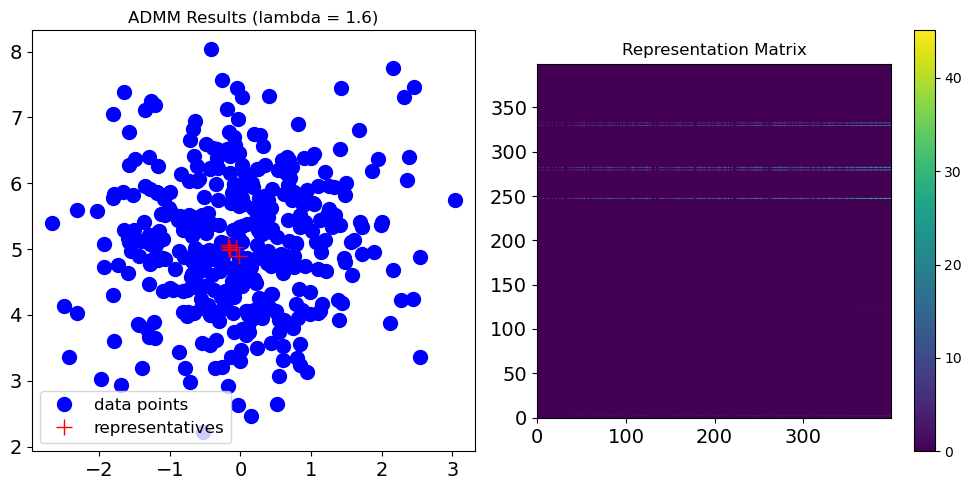

In [242]:
import torch
import matplotlib.pyplot as plt
import time

# 设置设备为GPU，如果没有GPU则回退到CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 计算欧几里得距离
def euclidean_distance(X, Y):
    return torch.norm(X - Y, dim=0)

# 计算相似度矩阵
def computeDissimilarity(X, Y=None):
    if Y is None:
        Y = X

    # 使用广播机制计算欧几里得距离矩阵
    D = torch.norm(X.unsqueeze(2) - Y.unsqueeze(1), dim=0)
    return D
def plot_results(Y, Z, sInd, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # 将张量从 GPU 移动到 CPU，然后转换为 NumPy 数组
    axs[0].plot(Y[0, :].cpu().numpy(), Y[1, :].cpu().numpy(), 'o', linewidth=4, color='b', markersize=10, markerfacecolor='b')
    axs[0].plot(Y[0, sInd].cpu().numpy(), Y[1, sInd].cpu().numpy(), '+', linewidth=6, color='r', markersize=12)
    axs[0].legend(['data points', 'representatives'], fontsize=12)
    axs[0].set_title(title)
    axs[0].tick_params(labelsize=14)

    # 将张量从 GPU 移动到 CPU，然后转换为 NumPy 数组
    im = axs[1].imshow(Z.cpu().numpy())
    fig.colorbar(im, ax=axs[1])
    axs[1].set_title("Representation Matrix")
    axs[1].invert_yaxis()
    axs[1].tick_params(labelsize=14)

    plt.tight_layout()
    plt.show()


def computeLamdaMax(D, q):
    M, N = D.shape
    idx = torch.argmin(torch.sum(D, dim=1))

    rho_max = -float('inf')
    idxC = torch.arange(M, device=device)
    idxC = idxC[idxC != idx]
    
    if q == float('inf'):
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = torch.norm(v, p=1) / 2
            if p > rho_max:
                lamda_max = p
    elif q == 2:
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = torch.sqrt(torch.tensor(M, device=device)) * torch.norm(v) ** 2 / (2 * torch.sum(v))
            if p > rho_max:
                lamda_max = p

    return lamda_max

def z_solver(Z_old, lambda_val, p):
    Z_new = torch.zeros_like(Z_old, device=device)
    if lambda_val.numel() > 0:
        if p == 2:
            norm_Z_old = torch.norm(Z_old, dim=1)
            r = torch.maximum(norm_Z_old - lambda_val, torch.tensor(0.0, device=device))
            Z_new = (r / (r + lambda_val)).unsqueeze(1) * Z_old
        elif p == 1:
            Z_new = torch.maximum(torch.abs(Z_old) - lambda_val.unsqueeze(1), torch.tensor(0.0, device=device)) * torch.sign(Z_old)
        elif p == float('inf'):
            Z_new = torch.zeros_like(Z_old, device=device)
            D, N = Z_old.shape
            for j in range(D):
                y, t = Z_old[j, :], lambda_val[j]
                x = y.clone()
                o = torch.argsort(torch.abs(y), descending=True)
                z = y[o]
                cs = torch.cumsum(torch.abs(z[:-1]), dim=0) / torch.arange(1, len(z), device=device)
                cs -= t / torch.arange(1, len(z), device=device)
                d = cs > torch.abs(z[1:])
                cut_index = len(y) if torch.sum(d) == 0 else torch.min(torch.nonzero(d))
                zbar = torch.mean(torch.abs(z[:cut_index]))
                if cut_index < len(y):
                    x[o[:cut_index]] = torch.sign(z[:cut_index]) * torch.maximum(zbar - t / cut_index, torch.abs(z[cut_index]))
                else:
                    x[o[:cut_index]] = torch.sign(z[:cut_index]) * torch.maximum(zbar - t / cut_index, torch.tensor(0.0, device=device))
                    
                Z_new[j, :] = x
                
    return Z_new

def solver_simplex(U):
    m, N = U.shape
    V = torch.sort(U, dim=1, descending=True)[0]  # Sorting the elements of vector V
    activeElementSet = torch.arange(N, device=device)
    theta = torch.zeros(N, device=device)
    i = 0
    while activeElementSet.numel() > 0 and i < m:
        idx = (V[i, activeElementSet] - (torch.sum(V[0:i+1, activeElementSet], dim=0) - 1) / (i + 1)) <= 0
        theta[activeElementSet[idx]] = (torch.sum(V[0:i, activeElementSet[idx]], dim=0) - 1) / i
        activeElementSet = activeElementSet[~idx]
        i += 1
    if activeElementSet.numel() > 0:
        theta[activeElementSet] = (torch.sum(V[0:m, activeElementSet], dim=0) - 1) / m
    C = torch.maximum(U - theta.unsqueeze(0).repeat(m, 1), torch.tensor(0.0, device=device))
    return C

def solve_DS3_ADMM(D, p, lamda, maxIter):
    M, N = D.shape

    C1 = torch.eye(M, N, device=device)
    lamda_var = torch.zeros((M, N), device=device)
    mu = 1e-1
    epsilon = 1e-7

    error1 = 2 * epsilon
    error2 = 2 * epsilon
    dummy_D = torch.ones(D.shape[0], device=device)
    lamda_reg = lamda * computeLamdaMax(D, p)
    
    k = 0
    while (error1 > epsilon or error2 > epsilon) and (k < maxIter):

        # Update Z
        Z = z_solver(C1 - (lamda_var + D) / mu, lamda_reg / mu * dummy_D, p)
        # Update C
        C2 = solver_simplex(Z + lamda_var / mu)
    
        # Update lamda_var
        lamda_var = lamda_var + mu * (Z - C2)

        # Update errors
        error1 = torch.sum(torch.abs(Z - C2)) / (Z.shape[0] * Z.shape[1])
        error2 = torch.sum(torch.abs(C1 - C2)) / (Z.shape[0] * Z.shape[1])
        
        if k % 100 == 0:
            print(f"||Z - C||₂ = {error1.item():.2e}, ||C1 - C2||₂ = {error2.item():.2e},  iteration = {k}")

        # Update iteration counter
        k += 1
        
        C1 = C2

    return Z

def computeLamdaMax(D, q):
    M, N = D.shape
    idx = torch.argmin(torch.sum(D, dim=1))

    rho_max = -float('inf')
    idxC = torch.arange(M, device=device)
    idxC = idxC[idxC != idx]
    
    if q == float('inf'):
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = torch.norm(v, p=1) / 2
            if p > rho_max:
                lamda_max = p
    elif q == 2:
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = torch.sqrt(torch.tensor(M, device=device)) * torch.norm(v) ** 2 / (2 * torch.sum(v))
            if p > rho_max:
                lamda_max = p

    return lamda_max

def findRepresentatives(matrix, ratio=0.1):
    num_rows = matrix.shape[0]
    row_norms = torch.norm(matrix, p=float('inf'), dim=1)

    selected_indices = torch.where(row_norms >= ratio * torch.max(row_norms))[0]

    norms_selected = torch.norm(matrix[selected_indices, :], p=2, dim=1)
    sorted_indices = selected_indices[torch.argsort(norms_selected, descending=True)]
    return sorted_indices

beta = 0.5  
tau = 1.0  
p = 2
maxIter = 3000

# Generate source and target sets
torch.manual_seed(42)
# Parameters
num_groups = 1
points_per_group = 400
offsets = torch.tensor([[0, 5], [5, 0], [-5, 0]], device=device)

# Initialize an empty list to store groups of points
X_groups = []

# Generate each group of points with the corresponding offset
for offset in offsets[:num_groups]:
    X_group = torch.randn(2, points_per_group, device=device) + offset.unsqueeze(1)
    X_groups.append(X_group)

# Concatenate all groups of points along the second axis
X = torch.hstack(X_groups)

# Set Y equal to X
Y = X

# Compute dissimilarity matrix
D = computeDissimilarity(X, Y)
D /= torch.max(D)

lamda = 1.6

start_time_ADMM = time.time()
Z_ADMM = solve_DS3_ADMM(D, p, lamda, maxIter)
end_time_ADMM = time.time()
ADMM_time = end_time_ADMM - start_time_ADMM
print("ADMM Parallel computation time (Best Case): ", ADMM_time / (num_groups * points_per_group))
sInd_numpy = findRepresentatives(Z_ADMM)
plot_results(Y, Z_ADMM, sInd_numpy, "ADMM Results (lambda = {})".format(lamda))


In [213]:
p

2

C:\Users\96446\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


||Z - C||₂ = 8.25e-01, ||C1 - C2||₂ = 8.01e-01,  iteration = 0

||Z - C||₂ = 4.83e-13, ||C1 - C2||₂ = 1.12e-02,  iteration = 100

||Z - C||₂ = 2.43e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 200

||Z - C||₂ = 4.34e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 300

||Z - C||₂ = 6.57e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 400
||Z - C||₂ = 6.96e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 500

||Z - C||₂ = 6.76e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 600

||Z - C||₂ = 7.94e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 700

||Z - C||₂ = 6.66e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 800

||Z - C||₂ = 8.75e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 900

||Z - C||₂ = 6.50e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 1000
||Z - C||₂ = 4.56e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 1100

||Z - C||₂ = 3.31e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 1200

||Z - C||₂ = 7.72e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 1300

||Z - C||₂ = 6.00e-17, ||C1 - C2||₂ = 1.12e-02,  iteration = 1400

||Z - C||

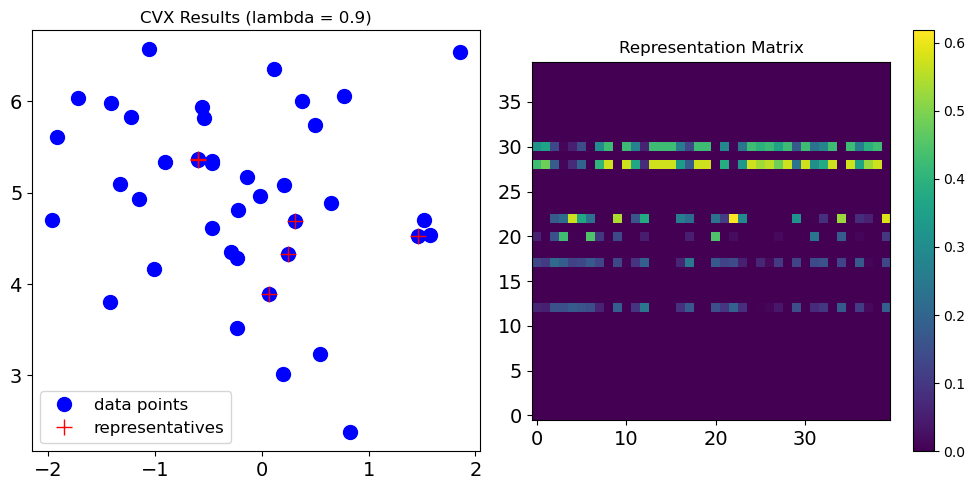

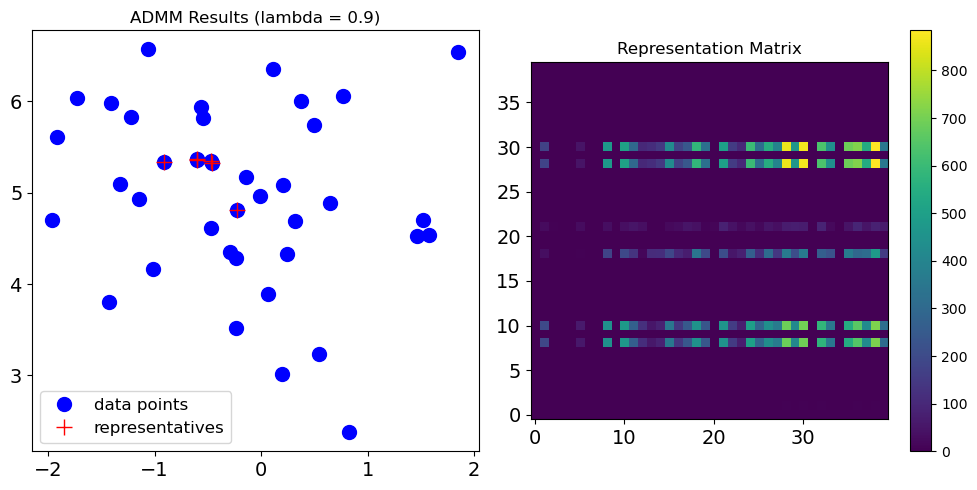

In [214]:
start_time_ADMM = time.time()
Z_ADMM = solve_DS3_ADMM(D, p, lamda, maxIter)
end_time_ADMM = time.time()
ADMM_time = end_time_ADMM - start_time_ADMM
print("ADMM Parallel computation time (Best Case): ", ADMM_time / (num_groups * points_per_group)  )
sInd_numpy = findRepresentatives(Z_ADMM)
plot_results(Y, Z_ADMM, sInd_numpy, "ADMM Results (lambda = {})".format(lamda))

In [202]:
Rnp.sum(Z_ADMM, axis=0)

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,   116.06146168,  4333.20730447,  1748.46288675,
           0.        ,  5591.86507296,  1320.55679039,   688.0917498 ,
        6355.82502229,  2550.87955221,  6471.86788942,  4187.56484956,
        9853.33126296,  6737.13961564, 10914.01508114,     0.        ,
        9339.63251835,  5270.09022529,     0.        ,  8976.92226619,
        9691.26157128,  7535.39399972, 13210.92433306,  5848.99899533])

In [80]:
-1.284882e-16

-1.284882e-16

### Outlier Detection

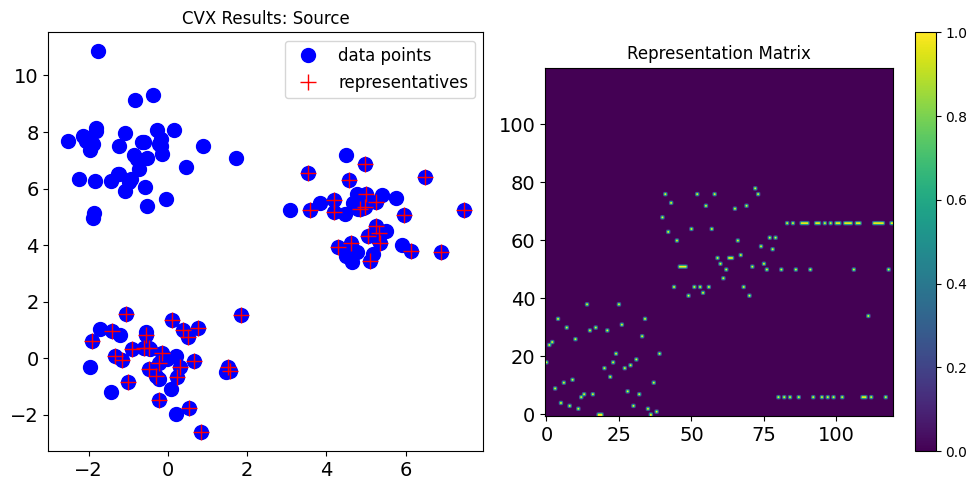

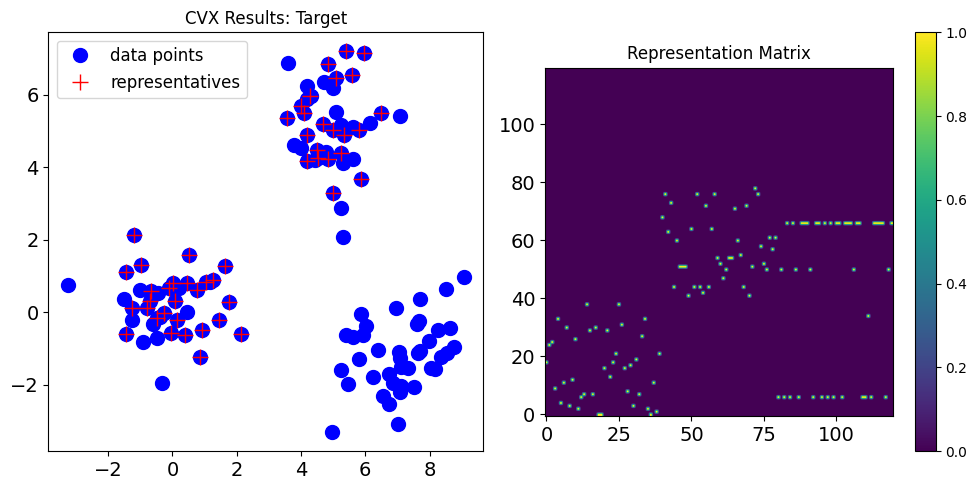

In [21]:
def compute_w(D, beta, tau):
    min_distances = np.min(D, axis=0)  # Find the minimum distance for each column (j)
    w = beta * np.exp(-min_distances / tau)
    return w

def solve_DS3_cvx_error(D, p, lamda, w):
    M, N = D.shape

    Z = cp.Variable((M, N), boolean=True)
    E = cp.Variable(N, nonneg=True)

    if p == float('inf'):
        objective = cp.Minimize(lamda * cp.sum(cp.max(Z, axis=1)) + cp.trace(D.T @ Z) + cp.sum(w * E))
    elif p == 2:
        objective = cp.Minimize(lamda * cp.sum(cp.norm(Z, axis=1)) + cp.trace(D.T @ Z) + cp.sum(w * E))
    else:
        raise ValueError('Unsupported value of p.')

    constraints = [cp.sum(Z, axis=0) == np.ones(N), E >= 0]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS_BB)

    return Z.value, E.value

np.random.seed(42)
num_groups = 3
points_per_group = 40
offsets_X = np.array([[0, 0], [5, 5], [-1, 7]])   # Reshape this array to (4, 2)
offsets_Y = np.array([[0, 0], [5, 5], [7, -1]])

# Initialize an empty list to store groups of points
Y_groups = []
X_groups = []

# Generate each group of points with the corresponding offset
for offset in offsets_X[:num_groups]:
    X_group = np.random.randn(2, points_per_group) + np.expand_dims(offset, axis=1)
    X_groups.append(X_group)

# Concatenate all groups of points along the second axis
X = np.hstack(X_groups)

# Generate each group of points with the corresponding offset
for offset in offsets_Y[:num_groups]:
    Y_group = np.random.randn(2, points_per_group) + np.expand_dims(offset, axis=1)
    Y_groups.append(Y_group)

# Set Y equal to X
Y = np.hstack(Y_groups)

# Compute dissimilarity matrix
D = computeDissimilarity(X, Y)
D /= np.max(D)

lamda_outlier = 0.001

# w = compute_w(D, beta, tau)
w = 0.3
start_time_cvx = time.time()
Z_cvx_outlier, Z_error = solve_DS3_cvx_error(D, p, lamda_outlier, w)
end_time_cvx = time.time()
cvx_error_time = end_time_cvx - start_time_cvx

# print("CVX implementation time:", cvx_time)

sInd_cvx = findRepresentatives(Z_cvx_outlier)

plot_results(X, Z_cvx_outlier, sInd_cvx, "CVX Results: Source")
plot_results(Y, Z_cvx_outlier, sInd_cvx, "CVX Results: Target")

<a id="8"></a> 
### Results

In [22]:
%%latex
The results shows that the algorithm is efficient in finding the representatives from the source set that well encodes the target set. Data points are drawn from a mixture of three Gaussians. The regularization parameter  $\lambda > 0$ puts a trade-off between the encoding cost and the number of representatives, where a smaller value of $\lambda$ results in obtaining more representatives and vice versa. 

Left: Data points (blue circles) drawn from a mixture of three Gaussians and the representatives (red plus) found by the proposed optimization formulation. Dissimilarity matrix is made using euclidean distance between each pair of data points. As we increase $\lambda$, the number of representatives decreases. Right: Representation of Matrix Z obtained by the proposed algorithm. The nonzero rows of Z indicate indices of the representatives. In addition, entries of Z provide information about the association probability of each data point with each representative. 
For outlier detection, we can see that the proposed algorithm efficiently detects the outliers present in the source and the target set

<IPython.core.display.Latex object>

<a id="9"></a> 
### Conclusion

In [28]:
%%latex
The paper presented the technique to efficiently find the representative from the source set that could well encode the target set given the pairwise dissimilarities between them. The paper proposed a row sparsity regularized trace minimization formulation which can be solved using convex optimization. we experimented the optimization formulation using CVX which shows the efficacy of this algorithm. we also demonstrated the effect of regularizer in finding the representatives which well aligns with the paper's theory. The paper also provided an efficient implementation of the algorithm using ADMM approach which is highly parallelizable and further reduces the computation time. 

<IPython.core.display.Latex object>

<a id="10"></a> 
### Analysis

In [29]:
%%latex
ADMM runs faster as it supports parallel computation. Also, ADMM can solve problems with high input dimensions where CVX fails. However, experiment results shows that that ADMM needs bit high iteration to produce accurate results

<IPython.core.display.Latex object>

<a id="11"></a> 
### Drawbacks

In [1]:
%%latex
The technique presented in this paper works well only under appropriate similarity metric. Also, For observations which is sequential in nature, the optimization formulation mentioned in this paper fails as it does not take considers the structure of the data. However, this limitation has been addressed in the papers [2][3]

<IPython.core.display.Latex object>

<a id="12"></a> 
### Reference

[1] E. Elhamifar, G. Sapiro, and S. S. Sastry, “Dissimilarity-Based Sparse Subset Selection,” IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 38, no. 11, pp. 2182–2197, Nov. 2016, doi: 10.1109/TPAMI.2015.2511748.

[2] E. Elhamifar and S. Sastry, “Energy Disaggregation via Learning Powerlets and Sparse Coding,” Proceedings of the AAAI Conference on Artificial Intelligence, vol. 29, no. 1, Art. no. 1, Feb. 2015, doi: 10.1609/aaai.v29i1.9249.

[3] X. Zhang, Z. Zhu, Y. Zhao, and D. Kong, “Self-Supervised Deep Low-Rank Assignment Model for Prototype Selection,” pp. 3141–3147, 2018.

[4] J. Duchi, S. Shalev-Shwartz, Y. Singer, and T. Chandra, “Efficient projections onto the l1-ball for learning in high dimensions,” in Proceedings of the 25th international conference on Machine learning, in ICML ’08. New York, NY, USA: Association for Computing Machinery, Jul. 2008, pp. 272–279. doi: 10.1145/1390156.1390191.
